In [4]:
from helpers.benchmark import load_records_from_directory
import pandas as pd
from helpers.benchmark import filter_full_lifecycle, trim_on_benchmark



LOG_DIR = "data/stage_a"
df_raw = load_records_from_directory(LOG_DIR)



df = filter_full_lifecycle(df_raw, remove_cold=True)

STAGE_A_CONFIG = [("aws", 512, "gemm"), ("azure", 512, "gemm"), ("gcp", 512, "gemm"), ("alibaba", 512, "gemm")]
df = df[df.apply(lambda row: (row["provider"], row["memory_size_mb"], row["benchmark_type"]) in STAGE_A_CONFIG, axis=1)]

trimmed_df = pd.DataFrame()
for config in STAGE_A_CONFIG:
    provider, memory_size_mb, benchmark_type = config
    regions = df[(df["provider"] == provider) & (df["memory_size_mb"] == memory_size_mb) & (df["benchmark_type"] == benchmark_type)]["region"].unique()
    for region in regions:
        df_subset = df[(df["provider"] == provider) & (df["memory_size_mb"] == memory_size_mb) & (df["benchmark_type"] == benchmark_type) & (df["region"] == region)]
        trimmed_config_region_df = trim_on_benchmark(df_subset, group_on_timestamp=False, benchmark=benchmark_type)
        trimmed_df = pd.concat([trimmed_df, trimmed_config_region_df], ignore_index=True)

print("raw rows:", len(df_raw))
print("region-clean rows:", len(df))

print("trimmed rows:", len(trimmed_df))

# billed_alibaba_df = load_all_billed_alibaba(f"{LOG_DIR}/alibaba")
# df = inject_billed_alibaba(df, billed_alibaba_df)

# billed_azure_df = load_all_billed_azure(f"{LOG_DIR}/azure")
# df = inject_billed_azure(df, billed_azure_df)

# billed_gcp_df = load_all_billed_gcp(f"{LOG_DIR}/gcp")
# df = inject_billed_gcp(df, billed_gcp_df)

# billed_aws_df = load_all_billed_aws(f"{LOG_DIR}/aws")
# df = inject_billed_aws(df, billed_aws_df)





raw rows: 324863
region-clean rows: 74358
trimmed rows: 73545


In [5]:
REGION_LABEL_OVERRIDES = {
    # --- AWS ---
    "me-central-1": "ME-C1",
    "ap-southeast-7": "AP-SE7",
    "ap-southeast-5": "AP-SE5",
    "us-east-1": "US-E1",
    "ap-northeast-1": "AP-NE1",
    "ap-northeast-2": "AP-NE2",
    "eu-central-1": "EU-C1",
    "us-west-1": "US-W1",
    "eu-west-1": "EU-W1",
    "ap-south-1": "AP-S1",
    "ap-southeast-1": "AP-SE1",
    "sa-east-1": "SA-E1",
    "us-east-2": "US-E2",
    "eu-west-3": "EU-W3",
    "eu-west-2": "EU-W2",
    "eu-north-1": "EU-N1",

    # --- Alibaba (China) ---
    "cn-shanghai": "CN-SH",
    "cn-beijing": "CN-BJ",
    "cn-hangzhou": "CN-HZ",

    # --- GCP ---
    "asia-east1": "AS-E1",
    "asia-east2": "AS-E2",
    "asia-south1": "AS-S1",
    "asia-northeast1": "AS-NE1",
    "asia-northeast2": "AS-NE2",
    "us-central1": "US-C1",
    "us-east1": "US-E1",
    "us-east4": "US-E4",
    "us-west1": "US-W1",
    "europe-west1": "EU-W1",
    "europe-west2": "EU-W2",
    "southamerica-east1": "SA-E1",

    # --- Azure ---
    "eastus": "US-E",
    "westus": "US-W",
    "westus2": "US-W2",
    "eastasia": "AS-E",
    "centralindia": "IN-C",
    "koreacentral": "KR-C",
    "uksouth": "UK-S",
    "ukwest": "UK-W",
    "germanywestcentral": "DE-WC",
    "brazilsouth": "BR-S",
    "japaneast": "JP-E",
    "japanwest": "JP-W",
}


Saved: plots/stage_a/aws_512MB_regional.pdf


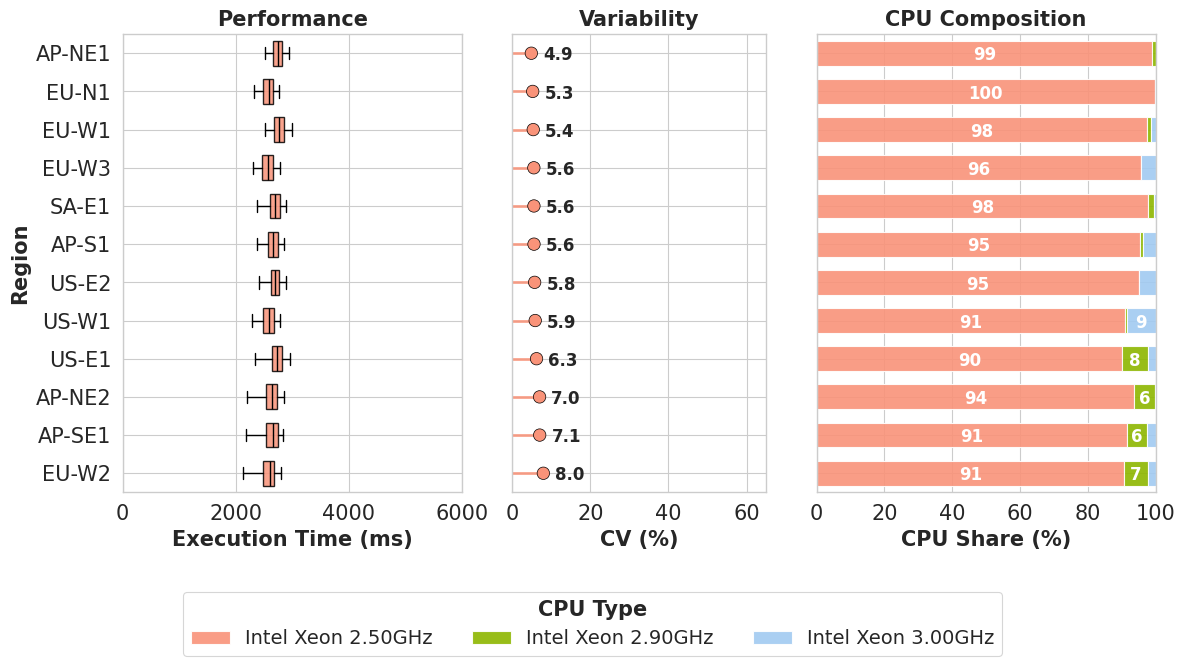

Saved: plots/stage_a/alibaba_512MB_regional.pdf


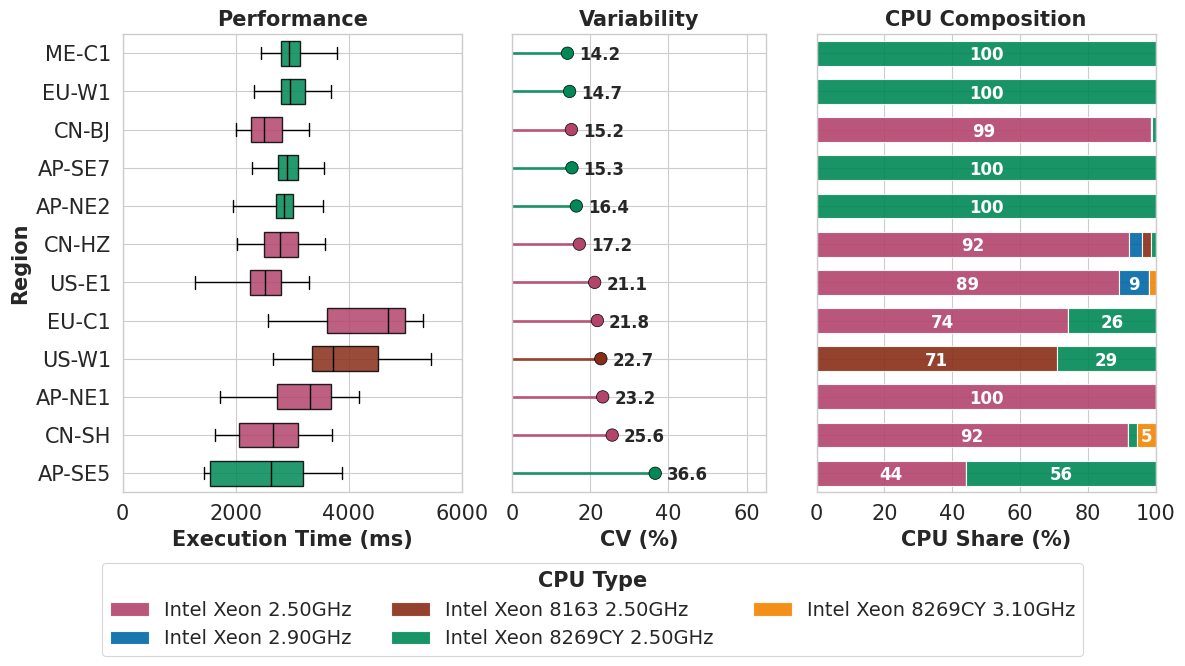

Saved: plots/stage_a/gcp_512MB_regional.pdf


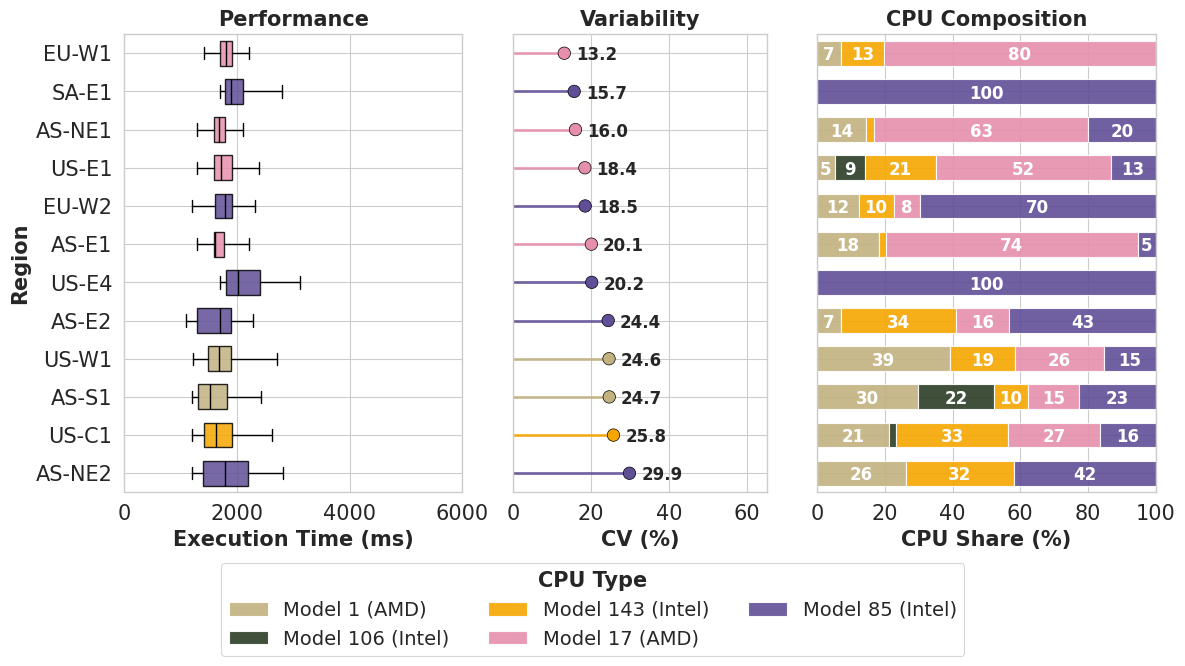

Saved: plots/stage_a/azure_512MB_regional.pdf


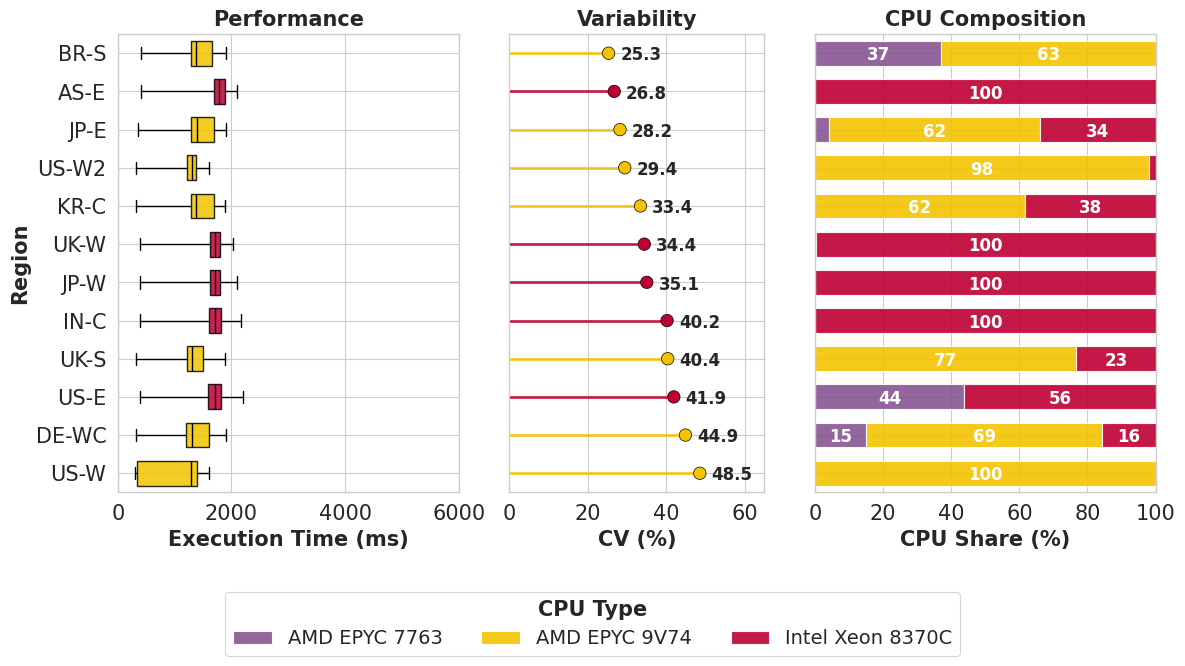

In [6]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from helpers.benchmark import metric_for_benchmark
from helpers.cpus import shorten_cpu_name, get_cpu_palette

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)


def create_regional_performance(
    df: pd.DataFrame,
    trimmed_df: pd.DataFrame,
    provider: str,
    out_dir: str = "plots/stage_a",
    memory_size: int = 512,
    show: bool = True,
):
    """
    Three-panel figure (INVOCATION-LEVEL):
      LEFT  : Performance distribution per region (boxplot of invocation times)
      MIDDLE: Variability (CV) lollipop (based on invocation times)
      RIGHT : CPU composition stacked bars (invocation shares)
    """

    # --- Filter data ---
    df_base = df[
        (df["provider"] == provider)
        & (df["memory_size_mb"] == memory_size)
        & (df["benchmark_type"] == "gemm")
    ].copy()

    df_trimmed_base = trimmed_df[
        (trimmed_df["provider"] == provider)
        & (trimmed_df["memory_size_mb"] == memory_size)
        & (trimmed_df["benchmark_type"] == "gemm")
    ].copy()

    metric = metric_for_benchmark("gemm")
    df_base = df_base.dropna(subset=[metric, "region", "cpu_type", "instance_id"])

    df_base[metric] = pd.to_numeric(df_base[metric], errors="coerce")
    df_base = df_base.dropna(subset=[metric])

    regional_stats = df_trimmed_base.groupby("region")[metric].agg(
        median="median",
        mean="mean",
        std="std",      
        n="size",
    )
    regional_stats["cv"] = (regional_stats["std"] / regional_stats["mean"]) * 100.0
    regions_sorted = regional_stats.sort_values("cv", ascending=False).index.tolist()
    regional_stats = regional_stats.reindex(regions_sorted)

    cpu_dist = df_base.groupby(["region", "cpu_type"]).size().unstack(fill_value=0)
    cpu_dist = cpu_dist.div(cpu_dist.sum(axis=1), axis=0) * 100
    cpu_dist = cpu_dist.reindex(regions_sorted)

    dominant_cpu = cpu_dist.idxmax(axis=1).to_dict()

    all_cpu_types = sorted(df_base["cpu_type"].unique())
    cpu_colors = get_cpu_palette(all_cpu_types, provider=provider)
    region_colors = [
        cpu_colors.get(dominant_cpu.get(r, "Unknown"), "#7f8c8d") for r in regions_sorted
    ]

    n_regions = len(regions_sorted)
    fig, (ax1, ax2, ax3) = plt.subplots(
        1, 3,
        figsize=(12, max(6, n_regions * 0.55)),
        gridspec_kw={"width_ratios": [1, 0.75, 1]},
    )
    y_pos = np.arange(n_regions)
    bar_height = 0.65

    # LEFT: Performance as horizontal boxplots (INVOCATION times)
    data_per_region = [
        df_base.loc[df_base["region"] == r, metric].values for r in regions_sorted
    ]

    finite_max = []
    for arr in data_per_region:
        if arr is not None and len(arr) > 0:
            finite_max.append(np.nanmax(arr))

    bp = ax1.boxplot(
        data_per_region,
        vert=False,
        positions=y_pos,
        widths=bar_height,
        patch_artist=True,
        showfliers=False,
        whis=(5, 95),
        medianprops=dict(color="black", linewidth=1.0),
        boxprops=dict(linewidth=1.0),
        whiskerprops=dict(linewidth=1.0, color= "black"),
        capprops=dict(linewidth=1.0),
    )


    for i, patch in enumerate(bp["boxes"]):
        patch.set_facecolor(region_colors[i])
        patch.set_alpha(0.85)

    ax1.set_yticks(y_pos)
    ax1.set_yticklabels([REGION_LABEL_OVERRIDES.get(r, r.upper()) for r in regions_sorted], fontsize=15)    
    ax1.set_ylabel("Region", fontweight="bold", fontsize=15)
    ax1.set_xlabel("Execution Time (ms)", fontweight="bold", fontsize=15)
    ax1.set_title("Performance", fontweight="bold", fontsize=15)
    ax1.set_xlim(0, 6000)

    # MIDDLE: CV lollipop (INVOCATION-level CV)
    cv_vals = regional_stats["cv"].to_numpy(dtype=float)

    for i, val in enumerate(cv_vals):
        if np.isfinite(val):
            ax2.hlines(
                y=y_pos[i], xmin=0, xmax=val,
                color=region_colors[i], linewidth=2, alpha=0.85
            )

    ax2.scatter(
        cv_vals,
        y_pos,
        color=region_colors,
        s=80,
        zorder=5,
        edgecolor="black",
        linewidth=0.5,
    )

    for i, val in enumerate(cv_vals):
        if np.isfinite(val):
            ax2.text(
                val + 3,
                y_pos[i],
                f"{val:.1f}",
                ha="left",
                va="center_baseline",
                fontweight="bold",
                fontsize=12,
            )

    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([])
    ax2.set_xlabel("CV (%)", fontweight="bold", fontsize=15)
    ax2.set_title("Variability", fontweight="bold", fontsize=15)
    ax2.set_xlim(0, 65)

    # RIGHT: CPU composition stacked bars (invocation share %)
    left = np.zeros(n_regions)
    for cpu_type in all_cpu_types:
        if cpu_type not in cpu_dist.columns:
            continue

        vals = cpu_dist[cpu_type].values
        ax3.barh(
            y_pos,
            vals,
            left=left,
            label=shorten_cpu_name(cpu_type),
            color=cpu_colors.get(cpu_type, "#7f8c8d"),
            alpha=0.9,
            edgecolor="white",
            height=bar_height,
        )

        for i, v in enumerate(vals):
            if v > 5:
                ax3.text(
                    left[i] + v / 2,
                    y_pos[i],
                    f"{v:.0f}",
                    ha="center",
                    va="center_baseline",
                    fontweight="bold",
                    fontsize=12,
                    color="white",
                )

        left += vals

    ax3.set_yticks(y_pos)
    ax3.set_yticklabels([])
    ax3.set_xlabel("CPU Share (%)", fontweight="bold", fontsize=15)
    ax3.set_title("CPU Composition", fontweight="bold", fontsize=15)
    ax3.set_xlim(0, 100)

    for ax in (ax1, ax2, ax3):
        ax.set_ylim(-0.5, n_regions - 0.5)
        ax.tick_params(axis="x", labelsize=15)

    handles, labels = ax3.get_legend_handles_labels()
    leg = fig.legend(
        handles,
        labels,
        title="CPU Type",
        title_fontsize=15,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.07),
        ncol=min(3, len(handles)),
        fontsize=14
    )
    leg.get_title().set_fontweight("bold")


    plt.tight_layout(rect=[0, 0.08, 1, 0.95])

    os.makedirs(out_dir, exist_ok=True)
    filename = f"{out_dir}/{provider}_{memory_size}MB_regional.pdf"
    plt.savefig(filename, bbox_inches="tight", dpi=150)
    print(f"Saved: {filename}")

    if show:
        plt.show()
    else:
        plt.close(fig)


for provider in ["aws", "alibaba", "gcp", "azure"]:
    create_regional_performance(df, trimmed_df=trimmed_df, provider=provider, show=True)


Saved: plots/stage_a/cpu_consistency_ecdf_raw_sns.pdf


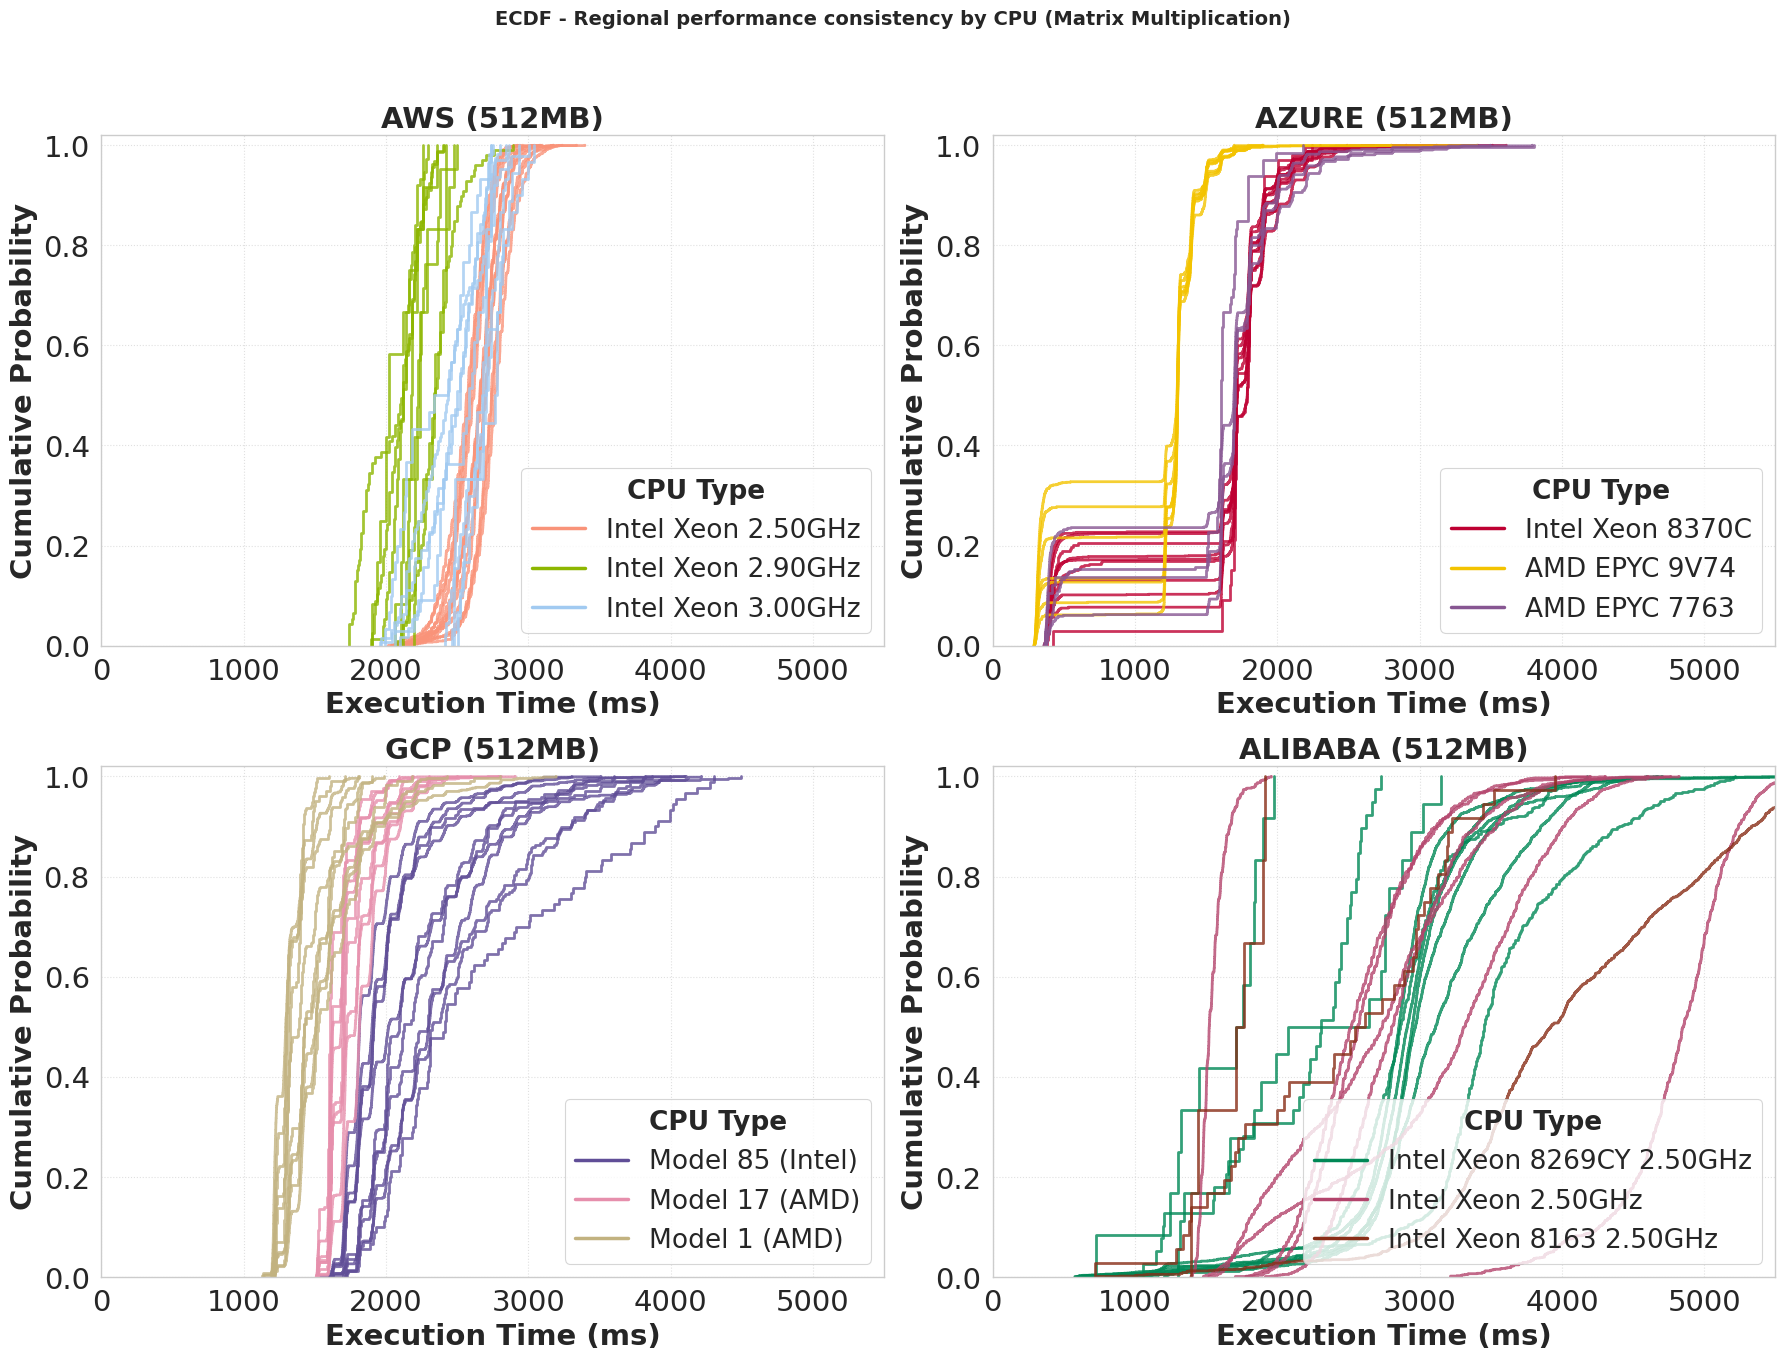

In [7]:
import os
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

from helpers.benchmark import metric_for_benchmark
from helpers.cpus import shorten_cpu_name, get_cpu_palette

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

def select_top_cpus_raw(df_prov: pd.DataFrame, top_n: int = 3, min_instances: int = 20) -> list[str]:
    """
    Select top CPUs by number of unique instances (stable), using raw (warm) rows.
    """
    if df_prov.empty:
        return []

    cpu_stats = (
        df_prov.groupby("cpu_type")["instance_id"]
        .nunique()
        .rename("n_instances")
        .to_frame()
    )
    cpu_stats = cpu_stats[cpu_stats["n_instances"] >= min_instances]

    return (
        cpu_stats.sort_values("n_instances", ascending=False)
        .head(top_n)
        .index
        .tolist()
    )


def plot_cpu_consistency_ecdf_raw(
    df: pd.DataFrame,
    providers: list[str] | None = None,
    memory_configs: dict[str, int] | None = None,
    benchmark_type: str = "gemm",
    top_n: int = 3,
    min_instances: int = 20,
    out_dir: str = "../holy/plots/StageA",
    show: bool = True,
):
    """
    ECDF plots using sns.ecdfplot: each line is one CPU type in one region.
    """

    if providers is None:
        providers = ["aws", "azure", "gcp", "alibaba"]
    if memory_configs is None:
        memory_configs = {p: 512 for p in providers}

    metric = metric_for_benchmark(benchmark_type)

    n = len(providers)
    ncols = 2
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 7 * nrows))
    axes = np.array(axes).reshape(-1)

    for idx, provider in enumerate(providers):
        ax = axes[idx]
        memory_size = memory_configs.get(provider, 512)

        df_prov = df[
            (df["provider"] == provider)
            & (df["memory_size_mb"] == memory_size)
            & (df["benchmark_type"] == benchmark_type)
        ].copy()


        df_prov = df_prov.dropna(subset=["cpu_type", "region", "instance_id", metric])
        top_cpus = select_top_cpus_raw(df_prov, top_n=top_n, min_instances=min_instances)
        # consistent CPU colors
        cpu_colors = get_cpu_palette(top_cpus, provider=provider)

        # axis limits
        xmax = df_prov.loc[df_prov["cpu_type"].isin(top_cpus), metric].max()
        ax.set_xlim(0, xmax * 1.05 if pd.notna(xmax) and xmax > 0 else None)
        ax.set_ylim(0, 1.02)

        total_instances = df_prov["instance_id"].nunique()
        legend_elements = []

        for cpu_name in top_cpus:
            cpu_data = df_prov[df_prov["cpu_type"] == cpu_name]
            regions = sorted(cpu_data["region"].dropna().unique())

            cpu_instances = cpu_data["instance_id"].nunique()
            share = (cpu_instances / total_instances * 100.0) if total_instances else 0.0

            cpu_clean = shorten_cpu_name(cpu_name)
            color = cpu_colors.get(cpu_name, "#7f8c8d")

            # Plot each region as separate ECDF line (same color)
            for region in regions:
                region_data = cpu_data[cpu_data["region"] == region]
                if len(region_data) < 5:
                    continue

                sns.ecdfplot(
                    data=region_data,
                    x=metric,
                    color=color,
                    alpha=0.8,
                    linewidth=2,
                    ax=ax,
                    legend=False
                )

            # Add to custom legend
            legend_elements.append(
                Line2D([0], [0], color=color, linewidth=2.5,
                       label=f"{cpu_clean}")
            )

        if legend_elements:
            leg = ax.legend(
                handles=legend_elements,
                title="CPU Type",
                fontsize=19,
                title_fontsize=19,
                loc="lower right",
            )
            leg.get_title().set_fontweight("bold")

        ax.set_xlim(0, 5500)
        ax.set_title(f"{provider.upper()} ({memory_size}MB)", fontweight="bold", fontsize=21)
        ax.set_xlabel("Execution Time (ms)", fontweight="bold", fontsize=21)
        ax.set_ylabel("Cumulative Probability", fontweight="bold", fontsize=21)
        ax.grid(True, linestyle=":", alpha=0.6)
        ax.tick_params(axis="both", which="major", labelsize=21)  # <-- add this
      

    for j in range(n, len(axes)):
        axes[j].axis("off")

    fig.suptitle(
        "ECDF - Regional performance consistency by CPU (Matrix Multiplication)",
        fontsize=14,
        fontweight="bold",
        y=0.99,
    )
    plt.tight_layout(rect=[0, 0.02, 1, 0.96])

    os.makedirs(out_dir, exist_ok=True)
    out_file = f"{out_dir}/cpu_consistency_ecdf_raw_sns.pdf"
    plt.savefig(out_file, bbox_inches="tight")
    print(f"Saved: {out_file}")

    if show:
        plt.show()
    else:
        plt.close(fig)


mixed_memory_config = {"aws": 512, "gcp": 512, "alibaba": 512, "azure": 512}

plot_cpu_consistency_ecdf_raw(
    df,
    providers=["aws", "azure", "gcp", "alibaba"],
    memory_configs=mixed_memory_config,
    benchmark_type="gemm",
    top_n=3,
    min_instances=5,
    out_dir="plots/stage_a",
)

In [8]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

from helpers.benchmark import metric_for_benchmark
from helpers.cpus import shorten_cpu_name, get_cpu_palette

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

def select_top_cpus_raw(df_prov: pd.DataFrame, top_n: int = 3, min_instances: int = 20) -> list[str]:
    if df_prov.empty:
        return []
    cpu_stats = (
        df_prov.groupby("cpu_type")["instance_id"]
        .nunique()
        .rename("n_instances")
        .to_frame()
    )
    cpu_stats = cpu_stats[cpu_stats["n_instances"] >= min_instances]
    return (
        cpu_stats.sort_values("n_instances", ascending=False)
        .head(top_n)
        .index
        .tolist()
    )

def plot_cpu_consistency_ecdf_raw_split(
    df: pd.DataFrame,
    providers: list[str] | None = None,
    memory_configs: dict[str, int] | None = None,
    benchmark_type: str = "gemm",
    top_n: int = 3,
    min_instances: int = 20,
    out_dir: str = "plots/stage_a",
    show: bool = False,
):
    """
    Creates one figure per provider (PDF), intended to be combined in LaTeX via subfigures.
    Preserves legend + typography choices from your adjusted version.
    """
    if providers is None:
        providers = ["aws", "azure", "gcp", "alibaba"]
    if memory_configs is None:
        memory_configs = {p: 512 for p in providers}

    metric = metric_for_benchmark(benchmark_type)
    os.makedirs(out_dir, exist_ok=True)

    for provider in providers:
        memory_size = memory_configs.get(provider, 512)

        df_prov = df[
            (df["provider"] == provider)
            & (df["memory_size_mb"] == memory_size)
            & (df["benchmark_type"] == benchmark_type)
        ].copy()

        df_prov = df_prov.dropna(subset=["cpu_type", "region", "instance_id", metric])
        top_cpus = select_top_cpus_raw(df_prov, top_n=top_n, min_instances=min_instances)

        # consistent CPU colors
        cpu_colors = get_cpu_palette(top_cpus, provider=provider)

        # one small figure per provider (tune size for your paper)
        fig, ax = plt.subplots(figsize=(8,6))

        ax.set_xlim(0, 5500)
        ax.set_ylim(0, 1.02)

        legend_elements = []

        for cpu_name in top_cpus:
            cpu_data = df_prov[df_prov["cpu_type"] == cpu_name]
            regions = sorted(cpu_data["region"].dropna().unique())

            cpu_clean = shorten_cpu_name(cpu_name)
            color = cpu_colors.get(cpu_name, "#7f8c8d")

            # Plot each region as separate ECDF line (same color)
            for region in regions:
                region_data = cpu_data[cpu_data["region"] == region]
                if len(region_data) < 5:
                    continue

                sns.ecdfplot(
                    data=region_data,
                    x=metric,
                    color=color,
                    alpha=0.8,
                    linewidth=2,
                    ax=ax,
                    legend=False,
                )
            legend_elements.append(
                Line2D([0], [0], color=color, linewidth=2.5, label=f"{cpu_clean}")
            )

        if legend_elements:
            leg = ax.legend(
                handles=legend_elements,
                title="CPU Type",
                fontsize=15,
                title_fontsize=15,
                loc="lower right",
            )
            leg.get_title().set_fontweight("bold")

        ax.set_xlabel("Execution Time (ms)", fontweight="bold", fontsize=21)
        ax.set_ylabel("Cumulative Probability", fontweight="bold", fontsize=21)
        ax.grid(True, linestyle=":", alpha=0.6)
        ax.tick_params(axis="both", which="major", labelsize=21)

        fig.tight_layout()

        out_file = f"{out_dir}/cpu_consistency_ecdf_raw_{provider}_{memory_size}mb.pdf"
        fig.savefig(out_file, bbox_inches="tight")
        print(f"Saved: {out_file}")

        if show:
            plt.show()
        else:
            plt.close(fig)

mixed_memory_config = {"aws": 512, "gcp": 512, "alibaba": 512, "azure": 512}

plot_cpu_consistency_ecdf_raw_split(
    df,
    providers=["aws", "azure", "gcp", "alibaba"],
    memory_configs=mixed_memory_config,
    benchmark_type="gemm",
    top_n=3,
    min_instances=5,
    out_dir="plots/stage_a",
    show=False,
)


Saved: plots/stage_a/cpu_consistency_ecdf_raw_aws_512mb.pdf
Saved: plots/stage_a/cpu_consistency_ecdf_raw_azure_512mb.pdf
Saved: plots/stage_a/cpu_consistency_ecdf_raw_gcp_512mb.pdf
Saved: plots/stage_a/cpu_consistency_ecdf_raw_alibaba_512mb.pdf
